# Контент-анализ Telegram-канала с применением SOTA-инструментов

Для контент-анализа был выбран telegram-канал **The Blueprint** – независимого
онлайн-издания о моде, красоте и современной культуре.

### Почему именно этот канал:
- Канал публикует **регулярные текстовые посты**, что делает его релевантным источником данных для анализа, поскольку регулярность обеспечивает достаточный объём данных для анализа.
- Содержимое канала отражает **актуальные культурные и потребительские тренды**. Такой контент позволяет с помощью современных NLP-инструментов выявлять латентные темы и анализировать поведение аудитории.
- Это **публичный и активный источник** с качественно оформленным текстом, что упрощает обработку и повышает достоверность анализа.



### Цель проекта:
Проанализировать содержание текстовых сообщений Telegram-канала The Blueprint в период с 1 марта по 31 мая, выявить ключевые темы, повторяющиеся паттерны и связи между постами, используя векторные представления текста и современные embedding-модели.


---

### Инструменты:

- sentence-transformers – модель paraphrase-multilingual-mpnet-base-v2 для эмбеддингов.

- faiss-cpu – векторный индекс и поиск (cosine/IP с L2-нормированием).

- numpy, pandas – подготовка данных, агрегации по неделям.

- scikit-learn и TfidfVectorizer/CountVectorizer для извлечения и взвешивания n-грамм.

- matplotlib – визуализации: бар-чарты, таймлайн, теплокарта.

- re – регулярные выражения для тематических паттернов и стоп-слов.

# Получение данных

- Импорт из: Telegram

- Формат: JSON

- Количество сообщений: 37438

- Период: с 01.03.2025 по 31.05.2025

In [1]:
import json

with open("result.json", "r", encoding = "utf-8") as f:
  data = json.load(f)

messages = []

for elem in data["messages"]:
  if type(elem) == dict:
    if type(elem["text"]) == list:
      message = ' '
      for el in elem["text"]:
        if type(el) == str:
          message += el
        else:
          message += el["text"]
      messages.append(message)
  if type(elem) == str:
    messages.append(elem)

print(messages)

[' В этом году журнал The New Yorker отмечает юбилей — ровно сто лет назад вышел его первый номер. С тех пор в еженедельнике сменилось четыре главных редактора, были сделаны сотни культовых обложек и написаны сотни текстов, в том числе от классиков и обладателей Пулитцеровской премии. Сегодня журнал проводит свой фестиваль, производит мерч, дает мастер-классы по фактчекингу и даже вдохновляет киноделов на создание новых фильмов.\n\nКак с момента основания The New Yorker удается оставаться эталонным и актуальным? Разбираем секрет успеха легендарного журнала по буквам — в большом алфавите The New Yorker.', ' Весь прошлый год мы только и слышали жалобы модных домов на падение продаж — Kering показывал удручающие -11% во втором квартале и -16% в третьем, похожие цифры демонстрировали и Ferragamo (-12,8%), и один только LVMH переживал рост на скромные 2%. \n\n2024 уже было окрестили «худшим годом для люкса», как внезапно к концу года оказалось, что все не так плохо, и даже самые горемычные 

In [2]:
with open("data.txt", "w", encoding = "utf-8") as f:
    f.writelines(messages)

- Были извлечены тексты из Telegram-канала **The Blueprint** и сохранены в формате 'txt'.

# Создание векторной базы данных с помощью SentenceTransformers

### Чистка текста

Используя регулярные выражения, очистим текст.

Так, в контексте настоящего кейса необходимо:
- Удаление эмодзи и символов (не несут смысловой нагрузки);
- Удаление ссылок (не важны для семантики, содержат бесполезные токены);
- Удаление лишних пробелов и переносов строк;
- Удаление повторов и хэштегов (могут мешать кластеризации).

---



Было принято решение не:

- Приводить текст к нижнему регистру (модели sentence transformers обучены работать со смешенным регистром);
- Удалять стоп-слова (они нужны для работы со смыслом в контексте).

In [3]:
import re

with open("data.txt", "r", encoding = "utf-8") as f:
    texts = f.readlines()

def clean_text(texts):
    cleaned = []
    for text in texts:
      text = re.sub(r"http\S+", "", text)  # удаляем ссылки
      text = re.sub(r"(The Blueprint|#\w+)", "", text) # удаление повторов и хэштегов
      text = re.sub(r"[^\w\s.,!?-]", "", text)  # удаляем эмодзи и спецсимволы
      text = re.sub(r"\s+", " ", text).strip()  # удаляем лишние пробелы
      cleaned.append(text)
    return cleaned

cleaned_texts = clean_text(texts)

with open("data.txt", "w", encoding="utf-8") as f:
    for line in cleaned_texts:
        f.write(line + "\n")

Теперь:
- Удалены лишние символы: нет ссылок, эмодзи, спецзнаков;
- Сохранены знаки препинания, что важно для дальнейшего анализа;
- Сохранена читаемость, без нарушений структуры предложений.

### Деление на чанки


Будет использоваться рекурсивный сплиттер, позволяющий делить текст с учётом особенностей синтаксиса.

In [4]:
with open("data.txt", "r", encoding = "utf-8") as f:
  texts = f.read()

In [5]:
texts

'В этом году журнал The New Yorker отмечает юбилей ровно сто лет назад вышел его первый номер. С тех пор в еженедельнике сменилось четыре главных редактора, были сделаны сотни культовых обложек и написаны сотни текстов, в том числе от классиков и обладателей Пулитцеровской премии. Сегодня журнал проводит свой фестиваль, производит мерч, дает мастер-классы по фактчекингу и даже вдохновляет киноделов на создание новых фильмов.\n\nКак с момента основания The New Yorker удается оставаться эталонным и актуальным? Разбираем секрет успеха легендарного журнала по буквам в большом алфавите The New Yorker. Весь прошлый год мы только и слышали жалобы модных домов на падение продаж Kering показывал удручающие -11 во втором квартале и -16 в третьем, похожие цифры демонстрировали и Ferragamo -12,8, и один только LVMH переживал рост на скромные 2.\n\n2024 уже было окрестили худшим годом для люкса, как внезапно к концу года оказалось, что все не так плохо, и даже самые горемычные из брендов немного пр

In [6]:
!pip install -U langchain
!pip install sentence_transformers

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 100
)

chunks = text_splitter.split_text(texts)

for i, chunk in enumerate(chunks):
  print(f"Chunk {i+1}:\n{chunk}\n{'-'*40}")

Chunk 1:
В этом году журнал The New Yorker отмечает юбилей ровно сто лет назад вышел его первый номер. С тех пор в еженедельнике сменилось четыре главных редактора, были сделаны сотни культовых обложек и написаны сотни текстов, в том числе от классиков и обладателей Пулитцеровской премии. Сегодня журнал проводит свой фестиваль, производит мерч, дает мастер-классы по фактчекингу и даже вдохновляет киноделов на создание новых фильмов.

Как с момента основания The New Yorker удается оставаться эталонным и актуальным? Разбираем секрет успеха легендарного журнала по буквам в большом алфавите The New Yorker. Весь прошлый год мы только и слышали жалобы модных домов на падение продаж Kering показывал удручающие -11 во втором квартале и -16 в третьем, похожие цифры демонстрировали и Ferragamo -12,8, и один только LVMH переживал рост на скромные 2.
----------------------------------------
Chunk 2:
2024 уже было окрестили худшим годом для люкса, как внезапно к концу года оказалось, что все не так

- Размер чанков оптимален для моделей Sentence Transformers.
- Чанки содержат связный, тематически однородный текст, оптимальный для смысловой векторизации.
- Текст литературно оформлен, значит, модель сможет точнее извлечь семантику.

### Создание векторной базы данных

In [8]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Загружаем модель для создания векторных представлений
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

# Кодируем чанки с помощью готовой модели
vectors = model.encode(
    chunks,
    normalize_embeddings=True,
    batch_size=64,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Создаём индекс с помощью FAISS:

In [9]:
!pip install faiss-cpu
import faiss

# Вычисляем размерность вектора
dimension = vectors.shape[1]
# Создаем индекс, числовой "каталог" текстов
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(np.array(vectors))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 63.7 MB/s eta 0:00:00


In [10]:
query = "Мода и тренды" # Вводим запрос
top_k = 15 # Выбираем, какое количество результатов нужно отобразить
vector = model.encode([query]) # Кодируем вектор

# Производим поиск
distances, indices = faiss_index.search(vector, top_k)

# Создаем каталог результатов
results = []
for i, idx in enumerate(indices[0]):
        results.append({
            "chunk": chunks[idx],
            "score": float(distances[0][i])
        })

# Выводим первый результат с ответом на вопрос
print("Top results for the query:")
for i, result in enumerate(results, 1):
  print(f"{i}. Chunk: {result['chunk']}\nScore: {result['score']}\n{'-'*40}")

Top results for the query:
1. Chunk: Мешковатые спортивные костюмы, отсылающие к уличной моде 1990-х и 2000-х, большие куртки, кепки, надетые задом наперед, массивные цепи и очки последователи стиля стремятся выглядеть круто, но при этом нарочито небрежно, даже немного по-дурацки. Назревает новый тренд?

35 лет назад на экраны вышел Твин Пикс и совершил настоющую революцию в мире телевидения. Дэвид Линч инфицировал убаюкивающую мыльную оперу вирусами насилия, секса, мистики и сюрреализма, навсегда изменив индустрию и доказав, что не бывает низких жанров.

Агент Купер, Лора Палмер, Черный вигвам и другие элементы вселенной великого сериала в нашем алфавите Дэвида Линча.

Этой зимой в Казани открылся самый масштабный и современный драмтеатр России. Теперь в городе два Театра им. Камала, которые смотрят друг на друга с разных берегов озера Кабан в историческом центре города.
Score: 5.700875282287598
----------------------------------------
2. Chunk: Несмотря на то что еще с сезона осеньзи

### **Так, из 15 чанков по запросу "Мода и тренды" максимально релевантными оказались:**

3\. Стратегии независимых брендов vs люкс на красных дорожках (сдвиг пиар-подходов, тренды продвижения).

4\. Топ-аксессуары с недель моды + бьюти-тренды AW’25/26.

5\. «Шаровары – главный тренд лета» (Chloé, Alaïa, Valentino).

7\. LV Resort 2026: мудборд + «проводные наушники» как модный аксессуар.

8\. Разнообразие в моде (Vogue, Black Style): срез индустриального тренда на инклюзию.

9\. «27 главных трендов сезона AW’25/26».

11\. Кризис высокой моды, доверие к брендам, Hermès/Brunello Cucinelli: макротренд индустрии.

14\. SS’25: «Grandma chic», шорты сезона – конкретные гардеробные тренды.

15\. Доля plus-size/ mid-size, инклюзия как устойчивый социальный тренд в индустрии.

13\. Влияние Blackpink на моду: культурный драйвер трендов.

---


###**Относительно релеватными:**

1\. Стрит-стайл 90/00-х и «назревает ли тренд?» – релевантно; далее «Твин Пикс», театр — не по теме.

2\. Джинсовые тренды (baggy/wide leg) релевантна; далее часть про Трейси Эмин.

6\. Дебюты креативных директоров – по теме; блок про Роберта Паттинсона выпадает.

10\. Тренд-репорт AW’25/26 – релевантно; архитектура и материал про седативы не подходят.

12\. Про новых креативных директоров – релевантно; «дофаминовые прыжки» не относятся к теме запроса.




###**Выявленные паттерны**

– Сезонные сводки трендов: регулярные обзоры коллекций AW’25/26 и SS’25 (одежда, аксессуары, бьюти), консолидирующие ключевые направления сезона.

– Индустриальные сдвиги: акценты на инклюзивность и смену креативных директоров как факторы, влияющие на позиционирование брендов и коммуникационные стратегии.

– Микротренды: закрепление отдельных мотивов (шаровары, джинсовые силуэты baggy/wide leg, аксессуарные акценты; в т. ч. «ретро-тех» – проводные наушники) в качестве повторяющихся сигналов.

– Культурные драйверы: влияние селебрити и поп-культуры (например, Blackpink), а также ностальгии по 1990–2000-ым; распространение эстетики «grandma chic».

###**Заключение**

Векторный поиск по эмбеддингам корректно выделяет тематическое ядро «мода и тренды» и соседние индустриальные/культурные аспекты, что подтверждается устойчивым присутствием сезонных обзоров и специфических микротрендов. Наличие сопутствующих нерелевантных фрагментов объясняется укрупнёнными единицами анализа (чанками), внутри которых совмещаются разные тематические блоки одного материала.


Для улучшения получаемых результатов детализируем запросы и, при необходимости, добавим пост-фильтрацию по ключевым словам или теме.



# Тематический анализ корпуса


## Выбор тем и детализация запросов


Исходя из цели проекта и специфики телеграм-канала **The Blueprint**, выберем три "рубрики" для выявления ключевых тем корпуса:

1) "Модная одежда и тренды";
2) "Новости культуры";
3) "Красота и здоровье".

In [11]:
query = "Модная одежда и тренды" # Вводим запрос
top_k = 15 # Выбираем, какое количество результатов нужно отобразить
vector = model.encode([query]) # Кодируем вектор

# Производим поиск
distances, indices = faiss_index.search(vector, top_k)

# Создаем каталог результатов
results = []
for i, idx in enumerate(indices[0]):
        results.append({
            "chunk": chunks[idx],
            "score": float(distances[0][i])
        })

# Выводим первый результат с ответом на вопрос
print("Top results for the query:")
for i, result in enumerate(results, 1):
  print(f"{i}. Chunk: {result['chunk']}\nScore: {result['score']}\n{'-'*40}")

Top results for the query:
1. Chunk: Несмотря на то что еще с сезона осеньзима 20242025 дизайнеры во главе с Миуччей Прадой и Miu Miu упорно пытаются вернуть в нашу жизнь скинни, инфлюенсеры и блогеры не торопятся вылезать из безразмерных моделей. Силуэты багги, бойфренд и wide leg прочно прижились в наших гардеробах и сердцах и по-прежнему остаются актуальными. Какие еще модели джинсов в тренде в этом теплом сезоне? И у каких брендов искать самые модные пары? Подсказывает Залина Амирова. Трейси Эмин довольно рано и скандально прославилась и так же рано получила коммерческое признание и для широкой публики до сих пор часто представляется скорее поп-звездой от искусства, чем серьезным художником. Достаточно вспомнить ее самые известные работы Все, с кем я когда-либо спала палатка, расшитая именами всех ее сексуальных партнеров, и Моя кровать неубранная постель, в которой художница, буквально, переживала депрессивный эпизод после расставания с бойфрендом.
Score: 5.615921497344971
-------

In [12]:
query = "Новости культуры" # Вводим запрос
top_k = 15 # Выбираем, какое количество результатов нужно отобразить
vector = model.encode([query]) # Кодируем вектор

# Производим поиск
distances, indices = faiss_index.search(vector, top_k)

# Создаем каталог результатов
results = []
for i, idx in enumerate(indices[0]):
        results.append({
            "chunk": chunks[idx],
            "score": float(distances[0][i])
        })

# Выводим первый результат с ответом на вопрос
print("Top results for the query:")
for i, result in enumerate(results, 1):
  print(f"{i}. Chunk: {result['chunk']}\nScore: {result['score']}\n{'-'*40}")

Top results for the query:
1. Chunk: Что происходит с в 2025-м, как изменилось отношение к культуре отмены и почему? Вспоминаем подробный таймлайн движения, который составила для нас Ольга Страховская. Лицо и пространство

В Москве открылись сразу две выставки, проводящие линии от неофициального искусства советского времени к современности. Persona в Галерее Алины Пинской исследует жанр портрета здесь представлены шестнадцать авторов, даты рождения самых старших и самых молодых разделяет больше столетия. А экспозиция в филиале ММОМА на Ермолаевском зритель погружается в очень конкретную тему личное пространство художника, физическое и ментальное.

Какими получились выставки в галерее Алины Пинской и Московском музее современного искусства рассказывает Олег Зинцов.
Score: 4.023166179656982
----------------------------------------
2. Chunk: В прошлом году коллеги из громко подвели итоги 10 лет в индустрии, а уже сегодня вечером планируют с размахом отметить выход полного списка пятого по

In [13]:
query = "Красота и здоровье" # Вводим запрос
top_k = 15 # Выбираем, какое количество результатов нужно отобразить
vector = model.encode([query]) # Кодируем вектор

# Производим поиск
distances, indices = faiss_index.search(vector, top_k)

# Создаем каталог результатов
results = []
for i, idx in enumerate(indices[0]):
        results.append({
            "chunk": chunks[idx],
            "score": float(distances[0][i])
        })

# Выводим первый результат с ответом на вопрос
print("Top results for the query:")
for i, result in enumerate(results, 1):
  print(f"{i}. Chunk: {result['chunk']}\nScore: {result['score']}\n{'-'*40}")

Top results for the query:
1. Chunk: Чем сузить поры и вернуть здоровый цвет лица? Вот средства для мужского ухода

Спасительная маска после тяжелых рабочих дней, жирный крем, который никогда не заканчивается, сыворотка для комбинированной кожи и бальзам для очень сухих губ в косметичке у event-продюсера и арт-директора Сергея Нестеренко мы нашли идеальные бьюти-средства для тех, кому нужен простой, но эффективный уход.

24 марта Международный День борьбы с депрессией. По данным ВОЗ, в России больше 5,6 миллиона человек страдают психическими расстройствами чаще всего из них встречаются тревожные и депрессивные. В случае последних, профессиональное лечение бывает просто необходимо.

Как понять, что нужна помощь специалиста? К кому идти за консультацией? И какие есть способы лечения? Рассказываем, как можно помочь себе и близким.
Score: 6.075754165649414
----------------------------------------
2. Chunk: К чему приведет полный отказ от уходовой косметики? Может ли появиться корка на лице

********

### Что видно по выдачам:

**1) Модная одежда и тренды**

Доминирующие темы:

Подиум-дайджесты AW’25/26 / Resort: сводки трендов после недель моды (NY–London–Milan–Paris).

Микротренды сезона:
шаровары (от Chloé/Alaïa/Valentino), «grandma chic», проводные наушники как аксессуар, шорты (бермуды/микро/джорты), летняя обувь (вьетнамки, рыбацкие сандалии, «домашние» силуэты).

Деним: устойчивость широких силуэтов (baggy/boyfriend/wide-leg) vs попытки вернуть скинни (Miu Miu/Prada).

Индустрия и инфлюенс: доминирование люксов на красных дорожках, эффект гостей/селебрити (Saint Laurent, Blackpink), «мид-сайз» вместо plus-size.

**Выводы:**

Весна 2025 у The Blueprint – комбо подиумных итогов + ностальгии 90/00-х + практики гардероба. Много разговоров о пиар-эффектах брендов, а также о сдвиге инклюзии (мид-сайз).

___

**2) Новости культуры**

Доминирующие темы:

Выставки и музеи: MMOMA, галерея Алины Пинской, Эрмитаж (ар-деко), Тейт Модерн 25 лет, гиды по музеям (в т.ч. Япония).

Фестивали/ивенты: Met Gala как культурный медиа-ивент, Каннский кинофестиваль, Евровидение, биеннале/фестивали медиаарта (Казань).

Книги и ярмарки: non/fiction, списки новинок.

Музыка/кино: обзоры релизов и туров; авторские разборы (Matthew Rankin).

Технологии & право: заметка про авторское право и ИИ.

**Выводы:**

Рубрика строится вокруг календаря ивентов с явными пиками в мае (Cannes/Met Gala/Eurovision) и сильной долей московской институциональной сцены.

___

**3) Красота и здоровье**

Доминирующие темы:

Уход за кожей: SPF/санскрин, увлажнение и водный баланс, минималистичный уход, мужской уход, посты с рекомендациями редакции.

Дерматология vs тренды TikTok: «не умываться/skin fasting» – позиция дерматологов, мифы и факты.

Макияж/волосы/тело: «французский» минимализм, ретро-укладки для красных дорожек, средства для сияния тела/автозагар.

Индустрия: «самые перспективные бьюти-бренды», эффект амбассадоров.

Ментальное здоровье: пост к Дню борьбы с депрессией.

**Выводы:**

Фокус на прагматичном уходе и просвещении, а не только новинках. Большой пласт – развенчание спорных практик из социальных сетей.

## Построение графиков

### Бар-чарты:

Для каждой рубрики для наглядности построим по 12 би-грамм:

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def topk_chunks(query, k=40):
    qv = model.encode([query], normalize_embeddings=True)
    D, I = faiss_index.search(qv, k)
    return [chunks[i] for i in I[0]]

STOP_UNI = set("""
и в на по за от для о к у с а но или что как уже еще ещё это этот эта этом
которые который какие какой чтобы можно нужно будет самый самая самые такой такая такие
вот очень просто более менее после перед при без со также однако где когда почему потому
""".split())

STOP_BI = {
    "потому что","специально для","уже сегодня","в этом","этом году",
    "что они","как они","лето вот","вот лучших","после сериала","больше всего",
    "сегодня вечером","дайджесте главных","обратить внимание","тем самым", "этой неделе",
    "неделе моды", "моды париже", "недель моды", "музее современного", "материалов этой", "один самых",
    "меньше чем", "одной самых", "главных материалов", "самых ожидаемых", "интервью директором", "амирова собрала",
    "института костюма", "прошедших недель", "собрали главные", "последние годы", "день рождения", "чем тут",
    "нашей эры", "ищете идеальный", "главных тренда", "всё что", "нужно знать", "специально для", "уже сегодня"
}

def keep_bigram(bg: str) -> bool:
    if bg in STOP_BI: return False
    w = bg.split()
    if len(w) != 2: return False
    w1, w2 = w
    if len(w1) < 3 or len(w2) < 3: return False
    if (w1 in STOP_UNI) or (w2 in STOP_UNI): return False
    return True

def top_bigrams_filtered(texts, top_n=12, min_df=3):
    vec = TfidfVectorizer(
        ngram_range=(2, 2),
        token_pattern=r"(?u)\b[а-яa-zё\-]{3,}\b",
        stop_words=None,
        min_df=min_df
    )
    X = vec.fit_transform(texts)
    terms = vec.get_feature_names_out()
    scores = np.asarray(X.sum(axis=0)).ravel()
    pairs = [(t, s) for t, s in zip(terms, scores) if keep_bigram(t)]
    pairs.sort(key=lambda x: x[1], reverse=True)

    # фолбэк: если мало — ослабляем отсев
    if len(pairs) < top_n:
        vec.set_params(min_df=1)
        X = vec.fit_transform(texts)
        terms = vec.get_feature_names_out()
        scores = np.asarray(X.sum(axis=0)).ravel()
        pairs = [(t, s) for t, s in zip(terms, scores) if keep_bigram(t)]
        pairs.sort(key=lambda x: x[1], reverse=True)

    return pairs[:top_n]

RUBRICS = ["Модная одежда и тренды","Новости культуры","Красота и здоровье"]

for q in RUBRICS:
    texts = topk_chunks(q, 40)          # ← реально берём 40
    pairs = top_bigrams_filtered(texts, top_n=12, min_df=3)
    print(f"\n=== {q} — топ биграмм ===")
    for t, s in pairs:
        print(f"{t}  ({s:.4f})")


=== Модная одежда и тренды — топ биграмм ===
залина амирова  (0.4531)
tom ford  (0.4391)
saint laurent  (0.3289)
dries van  (0.3100)
van noten  (0.3100)
louis vuitton  (0.3069)
black style  (0.2910)
superfine tailoring  (0.2910)
tailoring black  (0.2910)
стиле бохо  (0.2834)
dot days  (0.2692)
модный критик  (0.2517)

=== Новости культуры — топ биграмм ===
met gala  (0.7812)
современного искусства  (0.4407)
каннского кинофестиваля  (0.2766)
new york  (0.2758)
музыкальные события  (0.2616)
театральные премьеры  (0.2551)
black style  (0.2535)
superfine tailoring  (0.2535)
tailoring black  (0.2535)
анной винтур  (0.2453)
нижнем новгороде  (0.2417)
алины пинской  (0.2223)

=== Красота и здоровье — топ биграмм ===
met gala  (0.6705)
getty images  (0.3331)
tom ford  (0.2693)
креативного директора  (0.2542)
директором getty  (0.2221)
надежда кадышева  (0.2120)
intervals festival  (0.2060)
эльзы перетти  (0.2010)
the last  (0.1980)
миучча прада  (0.1971)
идеальный санскрин  (0.1936)
санскрин 

Отберём наиболее релевантные би-граммы и построим бар-чарты:

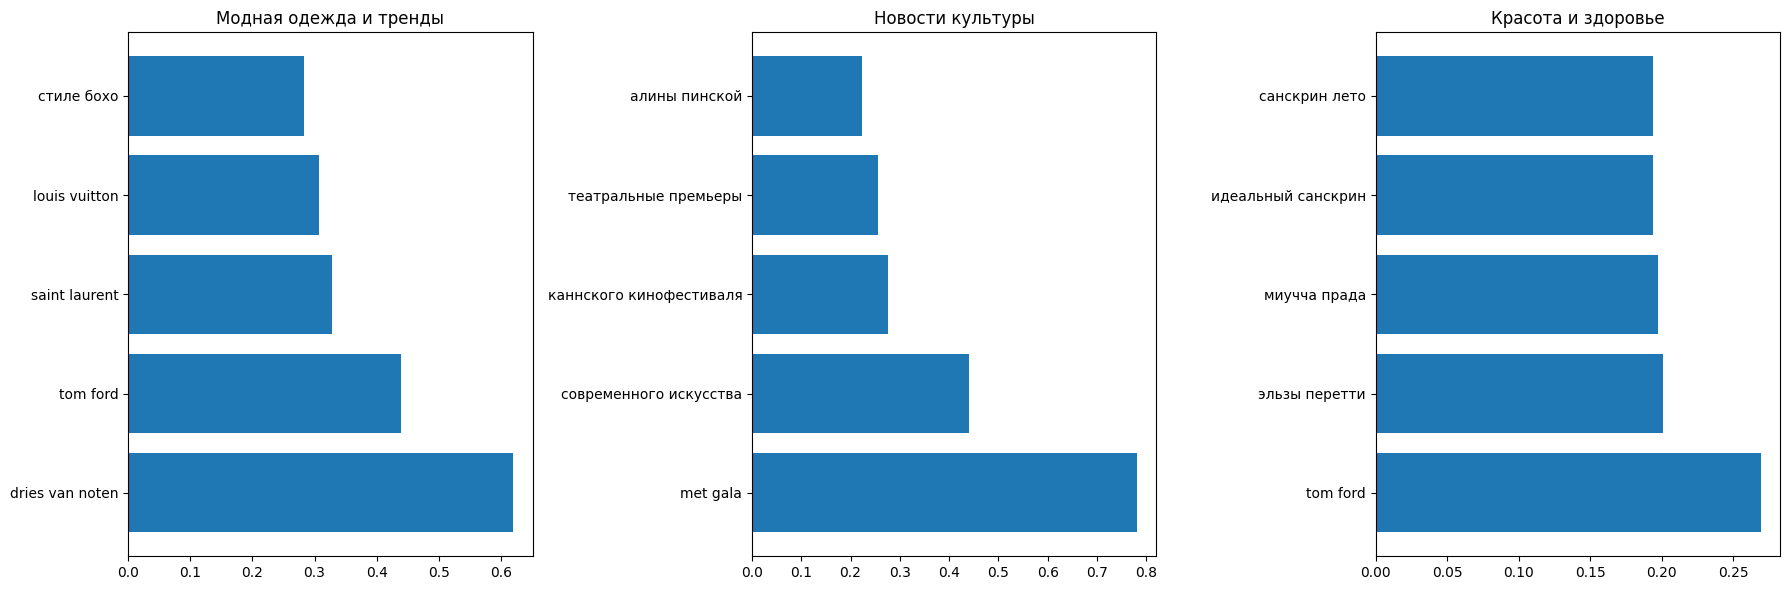

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# 1) вручную фиксируем выбранные биграммы и их веса
data = {
    "Модная одежда и тренды": {
        "dries van noten": 0.3100 + 0.3100,  # склейка биграмм
        "tom ford": 0.4391,
        "saint laurent": 0.3289,
        "louis vuitton": 0.3069,
        "стиле бохо": 0.2834,
    },
    "Новости культуры": {
        "met gala": 0.7812,
        "современного искусства": 0.4407,
        "каннского кинофестиваля": 0.2766,
        "театральные премьеры": 0.2551,
        "алины пинской": 0.2223,
    },
    "Красота и здоровье": {
        "tom ford": 0.2693,
        "эльзы перетти": 0.2010,
        "миучча прада": 0.1971,
        "идеальный санскрин": 0.1936,
        "санскрин лето": 0.1936,
    },
}

# 2) рисуем три горизонтальных бар-чарта
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (title, d) in zip(axes, data.items()):
    # сортируем по убыванию
    items = sorted(d.items(), key=lambda x: x[1], reverse=True)
    labels = [k for k, _ in items]
    scores = [v for _, v in items]
    y = np.arange(len(labels))[::-1]
    ax.barh(y, scores[::-1])
    ax.set_yticks(y)
    ax.set_yticklabels(labels[::-1])
    ax.set_title(title)

plt.tight_layout()
plt.show()

Из выделенных би-граммов и соответствующих бар-чартов, возможно сделать выводы:

Мода

Фокус брендоцентричный: Saint Laurent, Tom Ford, Louis Vuitton, Dries Van Noten – во главе.

Есть эстетики/предметы (стиль бохо, «неделя моды») – тренд-репорты и ретроспектива показов.

Вывод: весной канал обсуждает коллекции и силуэты топ-домов; тренды формулируются через кейсы брендов и итоги недель моды.

___

Культура

Главный драйвер – крупные ивенты: Met Gala доминирует; рядом современное искусство (музеи/выставки), театр, Каннский кинофестиваль.

Вывод: «Культура» в канале – это пересечение моды и арта: модные события (Met Gala) трактуются как культурные, плюс стабильный поток выставок/премьер.

___

Красота

Сигналы сезонного ухода: идеальный санскрин/санскрин лето.

Смешение с модной повесткой (имена вроде Tom Ford, Миучча Прада, Эльза Перетти), поскольку бьюти-темы часто привязаны к модным персонам/домам.

Вывод: весной – практический контент про SPF и лёгкий уход, но бьюти продолжает мигрировать из модной ленты.

### Теплокарта "биграмма × рубрика"

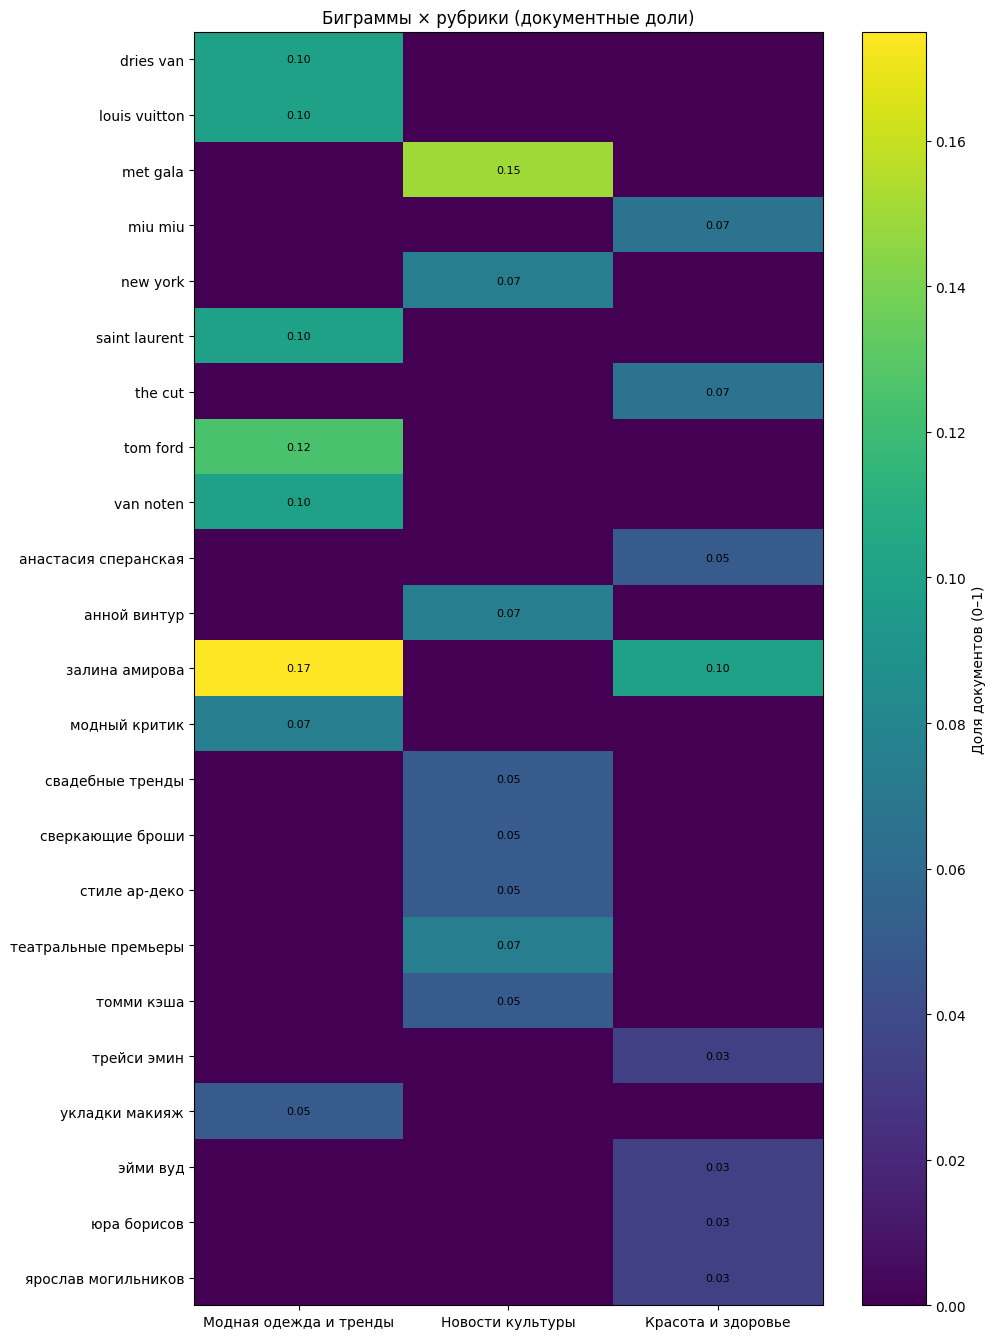

In [61]:
import re
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

# списки для чистки
STOP_UNI = set("""и в на по за от для о к у с а но или что как уже еще ещё это этот эта этом которые который какие какой чтобы можно нужно будет самый самая самые такой такая такие вот очень просто более менее после перед при без со однако где когда почему потому""".split())
STOP_BI = {
    "потому что","специально для","уже сегодня","в этом","этом году","что они","как они",
    "лето вот","вот лучших","после сериала","больше всего","сегодня вечером","дайджесте главных",
    "обратить внимание","тем самым","этой неделе","неделе моды","моды париже","недель моды",
    "музее современного","материалов этой","один самых","меньше чем","одной самых","главных материалов",
    "самых ожидаемых","интервью директором","амирова собрала","института костюма","прошедших недель",
    "собрали главные","последние годы","день рождения","чем тут","нашей эры","ищете идеальный",
    "главных тренда","всё что","нужно знать", "современное искусство", "современного искусства", "тех пор",
    "креативного директора", "креативных директоров", "массажем вашей", "отправиться лучшим", "тех кто", "этой недели",
    "самом деле", "совсем недавно", "стоит обратить", "своими любимыми", "самом деле", "лучшим массажем", "куда отправиться",
    "том числе", "знать про", "нашем материале", "зарубежных материалов", "косметику куда", "самых интересных", "нижнем новгороде",
    "дайджесте зарубежных", "каждый день", "телеграм-канала вишлист", "смотреть мае", "помощью нашего", "весной летом", "всему миру",
    "эти вопросы", "этой весной", "этой роли", "предметы одежды", "японии кроме", "вашей жизни"
}

def _normalize_text(s: str) -> str:
    # унифицируем пробелы/тире и приводим к нижнему регистру
    s = s.lower()
    s = re.sub(r"[–—−]", "-", s)           # все длинные тире -> "-"
    s = re.sub(r"\s+", " ", s).strip()      # схлопываем пробелы
    return s

def _keep_bigram(bg: str) -> bool:
    if bg in STOP_BI:
        return False
    w = bg.split()
    if len(w) != 2:
        return False
    return all((len(t) >= 3 and t not in STOP_UNI) for t in w)

def bigram_docshare(texts, topn=8, min_df=2):
    # нормализуем тексты заранее, чтобы термины совпадали со STOP_BI
    texts = [_normalize_text(t) for t in texts]
    cv = CountVectorizer(
        ngram_range=(2, 2),
        token_pattern=r"(?u)\b[а-яa-zё\-]{3,}\b",
        min_df=min_df,
        binary=True,
        lowercase=False  # понизили регистр
    )
    X = cv.fit_transform(texts)          # docs × terms
    terms = cv.get_feature_names_out()

    # применяем фильтр сразу к словарю
    mask = np.array([_keep_bigram(t) for t in terms])
    if mask.any():
        X = X[:, mask]
        terms = terms[mask]

    df = np.asarray(X.sum(axis=0)).ravel()
    idx = df.argsort()[-topn:][::-1]
    share = (df[idx] / X.shape[0])
    return dict(zip(terms[idx], share)), X.shape[0]

# 1) собираем top биграммы по рубрикам
per_rubric = {}
sizes = {}
for name, K in RUBRICS:
    T = topk_chunks(name, K)
    d, n = bigram_docshare(T, topn=8, min_df=2)
    per_rubric[name] = d; sizes[name] = n

# 2) объединяем словарь биграмм (строки матрицы)
vocab = sorted(set().union(*[d.keys() for d in per_rubric.values()]))

# 3) строим матрицу долей и рисуем
M = np.zeros((len(vocab), len(RUBRICS)))
for j, (name, _) in enumerate(RUBRICS):
    for i, term in enumerate(vocab):
        M[i, j] = per_rubric[name].get(term, 0.0)

plt.figure(figsize=(10, 0.5*len(vocab)+2))
im = plt.imshow(M, aspect="auto")
plt.xticks(range(len(RUBRICS)), [r[0] for r in RUBRICS], rotation=0)
plt.yticks(range(len(vocab)), vocab)
plt.colorbar(label="Доля документов (0–1)")
# подписи чисел внутри клеток
for i in range(len(vocab)):
    for j in range(len(RUBRICS)):
        v = M[i, j]
        if v > 0:
            plt.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=8)
plt.title("Биграммы × рубрики (документные доли)")
plt.tight_layout(); plt.show()

По данной тепловой карте можно сделать определённые выводы относительно того, что было популярно и о чём идет речь в постах The Blueprint в соответствии с каждой из трёх рубрик (Бренды, Met Gala, свадебные тренды, броши, Юра Борисов и т.д.).

Главным образом можно заметить не самые логично выделяющиеся биграммы в рубрике "Красота и здоровье" - это позволяет сделать вывод о том, что запрос нужно корректировать для отражения конкретных трендов за весну в этой сфере на графиках.

### Тайм-лайн (пики по неделям)

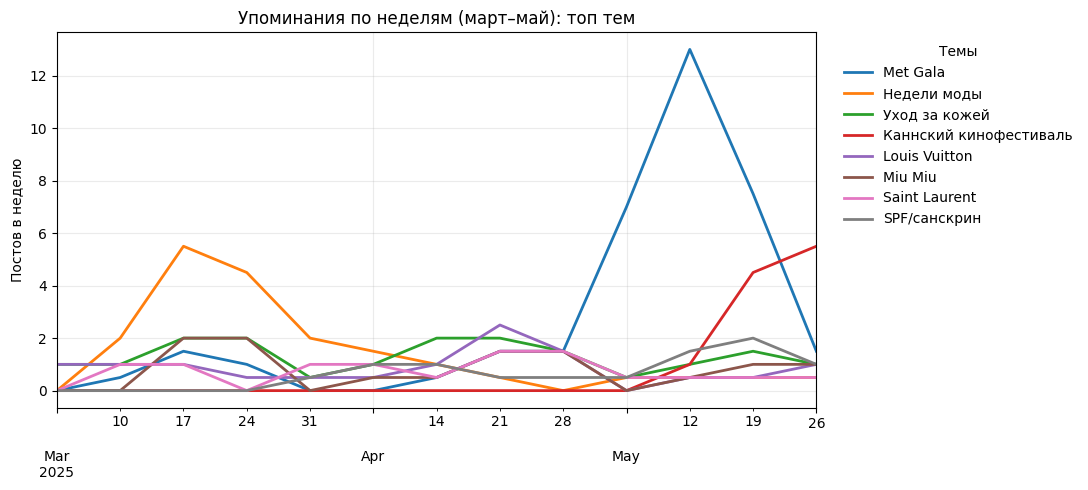

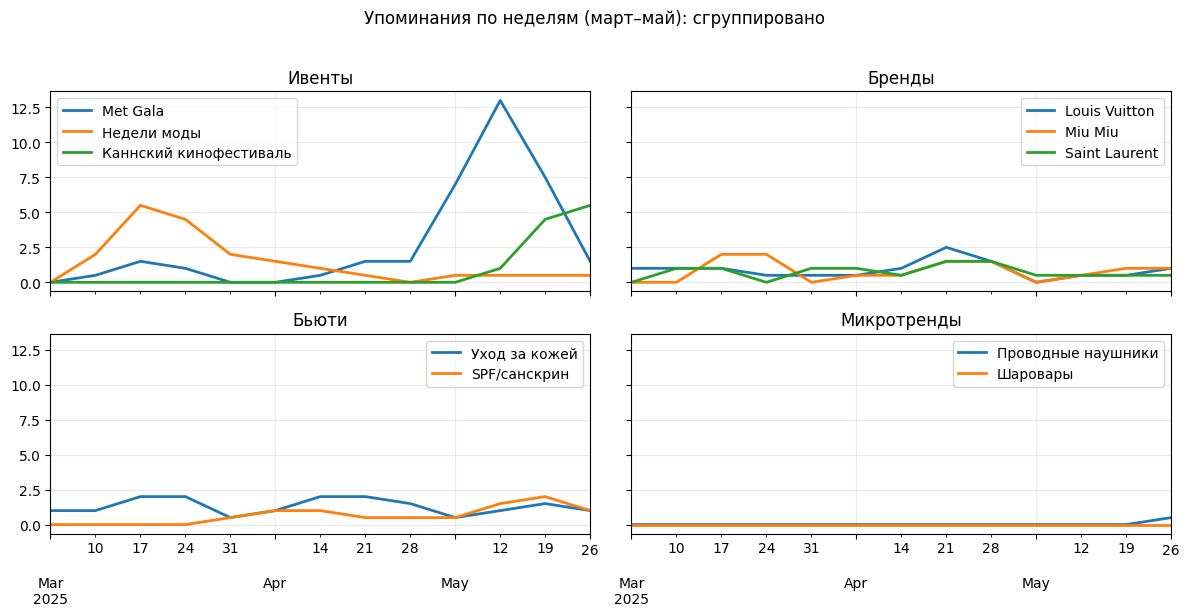

In [65]:
# Таймлайн упоминаний по неделям (март–май)
import json, re, pandas as pd, numpy as np, matplotlib.pyplot as plt

# 1) Загрузка и нормализация текста
def flatten_text(t):
    if isinstance(t, list):
        out = []
        for el in t:
            out.append(el if isinstance(el, str) else el.get("text", ""))
        return "".join(out)
    return t if isinstance(t, str) else ""

def normalize_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[–—−]", "-", s)      # длинные тире -> "-"
    s = re.sub(r"\s+", " ", s).strip()
    return s

with open("result.json","r",encoding="utf-8") as f:
    data = json.load(f)

rows = []
for m in data["messages"]:
    if isinstance(m, dict) and "date" in m and "text" in m:
        txt = normalize_text(flatten_text(m["text"]))
        rows.append({"date": pd.to_datetime(m["date"]), "text": txt})

df = pd.DataFrame(rows)
df = df[(df["date"] >= "2025-03-01") & (df["date"] <= "2025-05-31")].copy()

# 2) Темы
TOPICS = {
    # Ивенты
    "Met Gala": [
        r"\bmet\s*gala\b",
        r"\bбал(?:\s+|-)института\b",
        r"\bинститута\s+костюма\b",
    ],
    "Каннский кинофестиваль": [
        r"каннск\w+\s+кинофест\w+",
        r"\bcannes\b",
    ],
    "Недели моды": [
        r"недел[ьяи]\s+мод[ыаи]",
        r"\bfashion(?:\s+|-)week\b",
    ],

    # Бренды
    "Louis Vuitton": [
        r"\blouis\s+vuitton\b", r"\blv\b",
    ],
    "Saint Laurent": [
        r"\bsaint\s+laurent\b", r"\bysl\b",
    ],
    "Miu Miu": [
        r"\bmiu\s*miu\b",
    ],

    # Микротренды
    "Шаровары": [
        r"шаровар\w+",
    ],
    "Проводные наушники": [
        r"проводн\w+\s+наушник\w+",
    ],

    # Бьюти
    "SPF/санскрин": [
        r"\bspf\b", r"санскрин", r"солнцезащит\w+",
    ],
    "Уход за кожей": [
        r"уход\s+за\s+кож\w+", r"\bсыворотк\w+\b", r"\bкрем\w*\b", r"\bпор[аы]\b",
    ],
}

# 3) Подсчёт по неделям
start = df["date"].min().floor("D")
end   = df["date"].max().floor("D")
weekly_index = pd.date_range(start, end, freq="W-MON")  # недели, завершающиеся в понедельник

timeline = pd.DataFrame(index=weekly_index)

for name, pats in TOPICS.items():
    mask = pd.Series(False, index=df.index)
    for p in pats:
        mask |= df["text"].str.contains(p, regex=True, case=False)
    s = df.loc[mask].groupby(pd.Grouper(key="date", freq="W-MON")).size()
    timeline[name] = s.reindex(weekly_index, fill_value=0)

# 4) Один график: только топ-N тем
TOP_N = 8  # оставляем N самых «громких» линий
keep = timeline.sum(0).sort_values(ascending=False).head(TOP_N).index
plot_df = timeline[keep].rolling(window=2, min_periods=1).mean()  # лёгкое сглаживание

ax = plot_df.plot(figsize=(11,5), linewidth=2)
ax.set_title("Упоминания по неделям (март–май): топ тем")
ax.set_ylabel("Постов в неделю"); ax.set_xlabel("")
ax.grid(True, alpha=0.25); ax.margins(x=0)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, title="Темы")
plt.tight_layout(); plt.show()


# 4) Мини-графики по группам
groups = {
    "Ивенты": ["Met Gala","Каннский кинофестиваль","Недели моды"],
    "Бренды": ["Louis Vuitton","Saint Laurent","Tom Ford","Miu Miu","Valentino","Balenciaga","Dries Van Noten"],
    "Бьюти":  ["SPF/санскрин","Уход за кожей","Минималистичный макияж"],
    "Микротренды": ["Шаровары","Проводные наушники","Рыбацкие сандалии","Grandma chic","Шорты (лето)"],
}

fig, axes = plt.subplots(2, 2, figsize=(12,6), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (gname, topics) in zip(axes, groups.items()):
    cols = [t for t in topics if t in timeline.columns]
    if not cols:
        ax.axis("off"); continue
    T = timeline[cols]
    # показываем топ-3 внутри группы
    top_in_group = T.sum(0).sort_values(ascending=False).head(3).index
    T[top_in_group].rolling(2, min_periods=1).mean().plot(ax=ax, linewidth=2)
    ax.set_title(gname); ax.grid(True, alpha=0.25); ax.set_xlabel(""); ax.set_ylabel("")

fig.suptitle("Упоминания по неделям (март–май): сгруппировано", y=1.02)
plt.tight_layout(); plt.show()

Согласно представленным графикам:

Ивенты:

Met Gala – мощный пик во 2-й неделе мая (это и есть ночь Met Gala). До и после – заметные «хвосты» обсуждений.

Недели моды – максимумы приходятся на середину марта, затем плавный спад к апрелю.

Канны – рост начинается с середины мая, пик – конец мая.

👉 Лента двигается по календарю индустрии: март – дайджесты FW, начало мая – Met Gala, конец мая – Канны.

___

Бренды:

Louis Vuitton / Saint Laurent / Miu Miu – низкий, «фоновый» уровень с короткими всплесками (скорее привязка к ивентам и к отдельным материалам, чем самостоятельные инфоповоды).

Небольшой пик LV в конце апреля/начале мая может совпадать с обзорами коллекций/проектов.

___

Бьюти:

Уход за кожей – стабильные 1–2 поста в неделю почти весь период.

SPF/санскрин – сезонная динамика: подрастает в мае и достигает максимума перед летом. Это ожидаемая тема к жаре.

___

Микротренды

Проводные наушники – еле заметный «огонёк» в конце мая.

Шаровары – в таймлайне почти нет (тема яркая, но точечная: 1-2 лонгрида, а не частые упоминания).

___

Общий вывод:

Редакционный фокус закономерен: март – итоги недель моды → май – Met Gala → конец мая – Канны.
Бьюти-темы держатся фоном, SPF – выраженный сезонный пик. Бренды и микротренды упоминаются преимущественно в связке с ивентами.

# Итоги контент-анализа The Blueprint (март–май 2025)

### Ключевые результаты

Методика: векторный поиск (FAISS + paraphrase-multilingual-mpnet-base-v2) дал релевантные срезы без ручной разметки.

---

Рубрики и фокус:

Мода: устойчивые упоминания Louis Vuitton / Saint Laurent / Tom Ford; прикладные подборки (шорты/обувь); микротренды (шаровары, проводные наушники); эстетика grandma chic.

Культура: крупные инфоповоды – Met Gala, Каннский кинофестиваль; регулярные обзоры современного искусства и театральных премьер.

Красота: стабильный фон по уходу за кожей; выраженная сезонность SPF/санскрин (рост в мае).

---

Недельный таймлайн: март – пик «Недель моды» → тренд-репорты; начало–середина мая – всплеск Met Gala; конец мая – рост Канн; SPF плавно растёт к лету.

Связи: бренды «подсвечиваются» вокруг ивентов; бьюти усиливается в ивентные недели и по сезону; культура контекстуализирует модные темы.

---

**Практическая ценность:**

Планирование пиков: FW (март) → Met Gala (май-W2) → Канны (май-W3–W4).

Под ивенты – бренд-интеграции; к маю – акцент на SPF/летний уход; между пиками – прикладные «что купить/как носить».

### Направления дальнейшей работы

**Ограничения исследования:**

- Считаются упоминания, а не охваты/просмотры.

- Длинные чанки иногда включают «соседние» темы из одного поста.

- Пики брендов закономерно коррелируют с календарём ивентов (это учитывалось при интерпретации).

**Рекомендации по доработке:**

- Чанки: уменьшить до ~600–700 символов (overlap 100–150) для снижения «примесей».

- Запросы/выборка: детализировать формулировки, повысить top-k (до 40–60) для устойчивых n-грамм.

- Лексика: короткий стоп-лист для биграмм; опционально — лемматизация RU перед n-граммами.

- Пост-фильтрация: для «Красоты» требовать маркеры (spf|санскрин|кожа|крем|сыворотк|дерматолог|макияж).

- Визуализации: дополнить теплокартой «рубрика × топ-термины» и/или сгруппированным таймлайном (ивенты/бренды/бьюти/микротренды).

### TL;DR

**Краткое резюме:**

Весенняя повестка канала следует календарю индустрии; мода – брендоцентрична, рубрика о культуре завязана на новостях и ивентах, сфера красоты и здоровья фокусируется на бьюти-советах, косметике, советов бьюти-гуру и зависит от сезона. Метод дал быстрые и полезные срезы; для «идеала» нужны более мелкие чанки, детальнее запросы и лёгкая пост-фильтрация.